<a href="https://colab.research.google.com/github/Ramjeet-Dixit/IITM-AIML-Rdixit/blob/main/Discriminant_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Introduction**
This notebook demonstrates how discriminant functions define decision boundaries in classification.  
We explore both **non-discriminative** (KNN, Bayes, GMM) and **discriminative** (Perceptron) learning methods.

### **Objectives**
- Understand linear and non-linear decision boundaries.
- Visualize covariance impact on Gaussian distributions.
- Compare implicit vs explicit learning of discriminant functions.
- Implement perceptron learning and visualize results.

### **Instructions to Run**
1. Run all cells sequentially (Shift + Enter).
2. Install required libraries (if not already installed):
   ```bash
   pip install numpy matplotlib scikit-learn mlxtend seaborn
   ```
3. Each demo includes data generation, model fitting, and visualization using `mlxtend.plotting.decision_regions`.


In [ ]:

# Import required libraries
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import Perceptron
from mlxtend.plotting import plot_decision_regions
import seaborn as sns

sns.set(style='whitegrid')


## Demo 1 – KNN and Bayes: Implicit Boundary Learning

### **Introduction**
This demo focuses on predicting **customer churn** using transactional behavior and account balance data.  
We explore how discriminant functions can help separate customers likely to **stay** vs **leave** a service.  
The goal is to visualize and compare **linear** and **nonlinear** decision boundaries for churn classification.  

In this real-world scenario, understanding the decision boundary helps in:
- Identifying high-risk customers early.
- Tailoring retention strategies using interpretable models.
- Exploring whether linear models are sufficient or if nonlinear methods capture deeper patterns.

---

### **Data Description**
The dataset `churn_data.csv` contains the following columns:

| Column Name | Description |
|--------------|-------------|
| **avg_monthly_balance** | Average monthly account balance of the customer (normalized). |
| **avg_number_txns** | Average number of monthly transactions (normalized). |
| **churn** | Target variable indicating churn status (0 = Not Churned, 1 = Churned). |

Each record represents one customer’s summary statistics over a defined period.  
- Customers with **low balances** and **high transaction variation** are typically at higher churn risk.  
- The features provide a simple but powerful view of customer engagement behavior.

---

### **Instructions to Run**
1. Ensure that the file **`churn_data.csv`** is in the same directory as this notebook.  
2. Required libraries:
   ```bash
   pip install pandas numpy matplotlib scikit-learn mlxtend seaborn


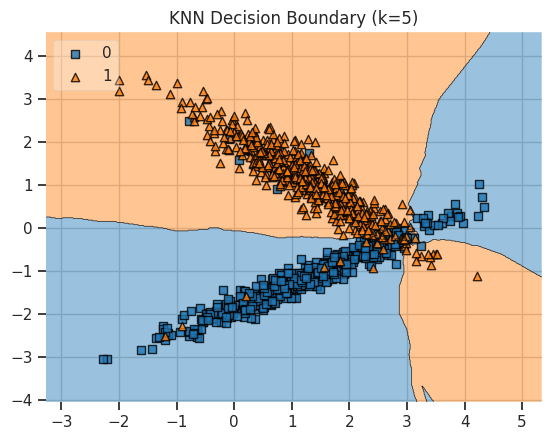

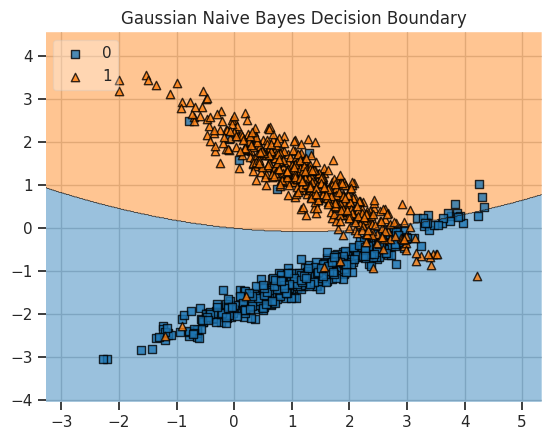

In [ ]:
df= pd.read_csv("churn_data.csv")
# Generate data
X = df.drop(columns = ['churn']).values #values convert dataframe into arrays
y = df['churn'].values
# KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
plot_decision_regions(X=X, y=y, clf=knn, legend=2)
plt.title('KNN Decision Boundary (k=5)')
plt.show()

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X, y)
plot_decision_regions(X=X, y=y, clf=gnb, legend=2)
plt.title('Gaussian Naive Bayes Decision Boundary')
plt.show()


## Demo 2 – Covariance & Decision Boundary Shape (Gaussian Distributions)

### **Description of the Steps**

In this section, we are visualizing how **Gaussian probability contours** can represent the data distribution for each churn class.

1. **Split the Data by Churn Status**  
   We separate customers into two groups — churned (`churn=1`) and non-churned (`churn=0`).  
   Each group’s data for `avg_monthly_balance` and `avg_number_txns` is extracted.

2. **Compute Mean and Covariance**  
   For each class, we calculate:  
   - **Mean vector:** Represents the center of the data cloud.  
   - **Covariance matrix:** Captures how the two features vary together (their orientation and spread).  
   These parameters define a **2D Gaussian distribution** for each class.

3. **Create a Grid of Points**  
   A fine grid is generated over the feature space.  
   Each grid point represents a possible `(balance, transaction)` pair.

4. **Compute Gaussian Probability Densities**  
   Using the mean and covariance, we compute the **probability density** for each grid point under both class distributions.  
   This gives us smooth continuous surfaces representing likelihood of each class.

5. **Plot the Contours and Data Points**  
   The contour lines (from Gaussian PDFs) visualize **regions of equal probability** for each class.  
   The scatter plot overlays the actual data points, showing how the two Gaussian distributions approximate the churn vs non-churn clusters.

This visualization demonstrates how **covariance and mean differences** define discriminant boundaries — the line (or curve) separating the two probability surfaces.


In [ ]:
# Split by churn status
class0 = df[df['churn'] == 0][['avg_monthly_balance', 'avg_number_txns']].values
class1 = df[df['churn'] == 1][['avg_monthly_balance', 'avg_number_txns']].values

# Compute mean and covariance for each class
mean0, cov0 = class0.mean(axis=0), np.cov(class0.T)
mean1, cov1 = class1.mean(axis=0), np.cov(class1.T)

# Create grid
x, y = np.mgrid[-1:4:.01, -2:3:.01]
pos = np.dstack((x, y))

# Compute Gaussian PDFs
rv0 = multivariate_normal(mean0, cov0)
rv1 = multivariate_normal(mean1, cov1)

# Plot
plt.figure(figsize=(7,6))
plt.contour(x, y, rv0.pdf(pos), colors='blue', alpha=0.6)
plt.contour(x, y, rv1.pdf(pos), colors='red', alpha=0.6)
plt.scatter(df['avg_monthly_balance'], df['avg_number_txns'], c=df['churn'], cmap='coolwarm', edgecolor='k')
plt.title('Empirical Gaussian Contours – Churn vs Non-Churn')
plt.xlabel('Average Monthly Balance')
plt.ylabel('Average Number of Transactions')
plt.show()

## Demo 3 – Gaussian Mixture Model (GMM): Complex Nonlinear Boundaries

In this part, we are using a **Gaussian Mixture Model (GMM)** to capture complex, nonlinear class boundaries between two groups of data.

1. **Fit Gaussian Mixtures for Each Class**  
   - We fit two separate **GMMs**, one for each class (`y=0` and `y=1`).  
   - Each GMM uses **two Gaussian components** (`n_components=2`) to model the data distribution more flexibly.  
   - Unlike a single Gaussian (which assumes a single elliptical shape), multiple components allow modeling irregular or multimodal shapes.

2. **Compute Posterior Probabilities for Each Grid Point**  
   - A fine grid of points is created covering the data space (`xx`, `yy`).  
   - For every grid point, we compute the **log-likelihood** under each model (`gmm0` and `gmm1`).  
   - These are exponentiated to get actual probabilities (`p0`, `p1`).

3. **Generate Decision Regions**  
   - The comparison `(p1 > p0)` determines which class has a higher probability for each point.  
   - This forms the **decision boundary** — the curve separating regions dominated by one class vs the other.

4. **Visualize the Boundary and Data Points**  
   - The contour plot (`contourf`) shows decision regions with soft, nonlinear transitions between classes.  
   - The scatter plot overlays the actual samples for reference.  

This visualization demonstrates how **GMMs generalize the Bayes classifier** by allowing multiple Gaussian clusters per class, leading to **nonlinear and flexible decision surfaces** that adapt to complex data distributions.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
# Extract features and target
X = df[['avg_monthly_balance', 'avg_number_txns']].values
y = df['churn'].values

# Standardize features for better GMM performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Fit GMM (2 components per class)
gmm0 = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm1 = GaussianMixture(n_components=2, covariance_type='full', random_state=42)

# Separate data by class
X0, X1 = X_scaled[y == 0], X_scaled[y == 1]
gmm0.fit(X0)
gmm1.fit(X1)

# Create grid for visualization
xx, yy = np.meshgrid(np.linspace(-2, 4, 200), np.linspace(-2, 3, 200))
pos = np.c_[xx.ravel(), yy.ravel()]

# Compute posterior probability for each class
p0 = np.exp(gmm0.score_samples(pos))  # probability under class 0
p1 = np.exp(gmm1.score_samples(pos))  # probability under class 1

# Decision boundary: where class 1 probability > class 0 probability
Z = (p1 > p0).astype(int).reshape(xx.shape)

# Plot decision regions and actual data points
plt.figure(figsize=(7, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.title('Gaussian Mixture Model (GMM) Decision Regions – Churn vs Non-Churn')
plt.xlabel('Avg Monthly Balance (Standardized)')
plt.ylabel('Avg Number of Transactions (Standardized)')
plt.show()

## Demo 4 – Perceptron: Direct Linear Discriminant Learning

### **Introduction**
In this demo, we apply the **Perceptron algorithm** to a real-world churn dataset to visualize how a **linear discriminant function** separates customers likely to churn from those who remain.

The Perceptron directly learns a **linear decision boundary** by iteratively updating its weights based on misclassified samples.  
It’s one of the earliest models that explicitly learns the discriminant function rather than modeling the data distribution.

---

### **Objective**
- Use the churn dataset to train a **Perceptron** classifier.
- Visualize how a linear boundary separates churn (1) vs non-churn (0) customers.
- Interpret how linear discriminant learning behaves on real customer data.

---

### **Data Description**
| Column | Description |
|---------|--------------|
| **avg_monthly_balance** | Average monthly account balance of the customer (normalized). |
| **avg_number_txns** | Average number of transactions (normalized). |
| **churn** | Target variable (0 = Not Churned, 1 = Churned). |

---

### **Instructions to Run**
1. Place `churn_data.csv` in the same directory as this notebook.  
2. Install dependencies if needed:
   ```bash
   pip install scikit-learn mlxtend matplotlib pandas numpy


In [ ]:
# Demo – Perceptron: Direct Linear Discriminant Learning on Churn Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions

# Load churn dataset
df = pd.read_csv("churn_data.csv")

# Extract features and target
X = df[['avg_monthly_balance', 'avg_number_txns']].values
y = df['churn'].values

# Standardize features (important for Perceptron convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Perceptron model
clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
clf.fit(X_scaled, y)

# Plot decision boundary
plt.figure(figsize=(7,6))
plot_decision_regions(X=X_scaled, y=y, clf=clf, legend=2)
plt.title('Perceptron Linear Decision Boundary – Churn vs Non-Churn')
plt.xlabel('Average Monthly Balance (Standardized)')
plt.ylabel('Average Number of Transactions (Standardized)')
plt.show()
